In [1]:
import numpy as np      
from scipy import stats
from scipy.fft import fft,fftfreq# Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from scipy.signal import savgol_filter



In [2]:
########## Import data ############
fname = 'u1.txt'
DD = []
with open( fname, 'r' ) as f :
    for line in f:
        line = line.strip()        
        columns = line.split(',')
        ddtmp = []
        for i in range(len(columns)):
            ddtmp.append(float(columns[i]))
        DD.append(ddtmp)
DD = np.array(DD)
LC = len(DD[:,0])
NC = len(DD[0,:])
print(LC,NC)
t = np.linspace(1,NC,NC)
t/=6.

MDx = np.mean(DD,axis=0)
SDx = np.std(DD,axis=0)


222 169


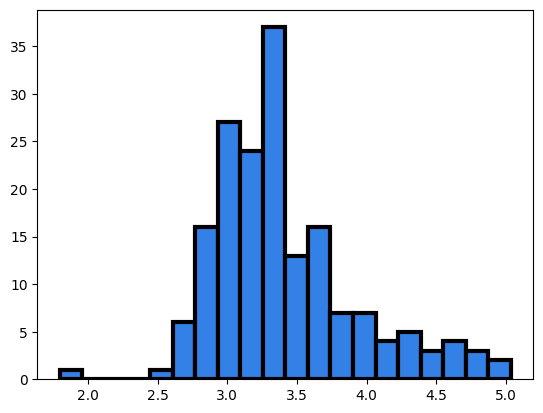

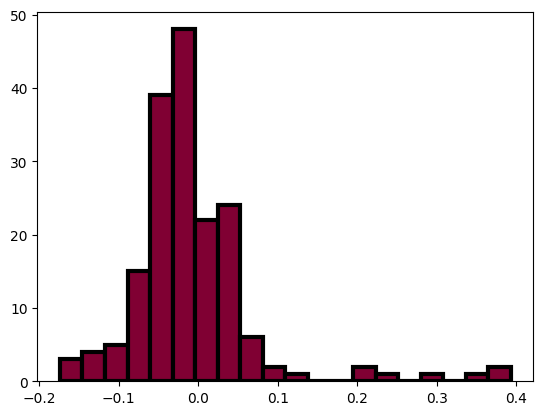

176
175
174
173
172
171
170


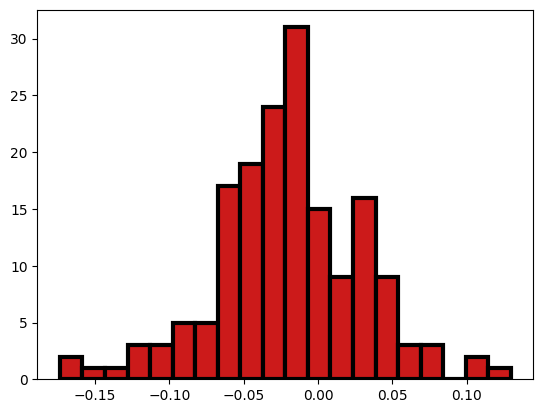

In [3]:

npol = 3
Fs = 1/6.  # Sampling rate
T = 1/Fs  # Sampling interval
Peaks = []
Vals = []
for i in range(LC):
    x = DD[i,:]
    x /= x[0]
    
    fxp = np.polyfit(t[36:],x[36:],1)
    Vals.append([fxp[0],fxp[1]])
    
    fxp = np.polyfit(t[:36],x[:36],2)
    me = np.mean(x[100:])
    Peaks.append([fxp[0],fxp[1],fxp[2]])

Peaks = np.array(Peaks)

yax = -Peaks[:,1]/(2*Peaks[:,0])

idx_good = np.arange(len(yax))
idx_bad = []

Zval_yax = (yax-np.mean(yax))/np.std(yax)
Prob = 1/np.sqrt(2*np.pi)*np.exp(-0.5*(Zval_yax)**2)
CCrit = Prob*len(Zval_yax)
############ Applying Chauvenets criterion to the position of the first pulse
yax_new = yax.copy()
while (np.min(CCrit) < 0.5):
    
    idx = np.argmin(CCrit)
    idx_bad.append(idx)
    idx_good = np.delete(idx_good, idx)
    
    Zval_yax = (yax[idx_good]-np.mean(yax[idx_good]))/np.std(yax[idx_good])
    Prob = 1/np.sqrt(2*np.pi)*np.exp(-0.5*(Zval_yax)**2)
    CCrit = Prob*len(Zval_yax)
    

plt.hist(yax[idx_good],20,edgecolor = 'k',facecolor = [.2,.5,.9],lw=3)
plt.show()

############ Applying Chauvenets criterion to slope of dynamics

Vals = np.array(Vals)
plt.hist(Vals[idx_good,0],20,edgecolor = 'k',facecolor = [0.5,0,0.2],lw=3)
plt.show()

yder = Vals[:,0]
Zval_yax = (yder[idx_good]-np.mean(yder[idx_good]))/np.std(yder[idx_good])
Prob = 1/np.sqrt(2*np.pi)*np.exp(-0.5*(Zval_yax)**2)
CCrit = Prob*len(Zval_yax)

while (np.min(CCrit) < 0.5):
    print(len(Zval_yax))
    idx = np.argmin(CCrit)
    idx_bad.append(idx_good[idx])
    idx_good = np.delete(idx_good, idx)
    
    Zval_yax = (yder[idx_good]-np.mean(yder[idx_good]))/np.std(yder[idx_good])
    Prob = 1/np.sqrt(2*np.pi)*np.exp(-0.5*(Zval_yax)**2)
    CCrit = Prob*len(Zval_yax)
    
plt.hist(Vals[idx_good,0],20,edgecolor = 'k',facecolor = [.8,.1,0.1],lw=3)
plt.show()

############ Now "idx_good" refer to the traces accepted by the method


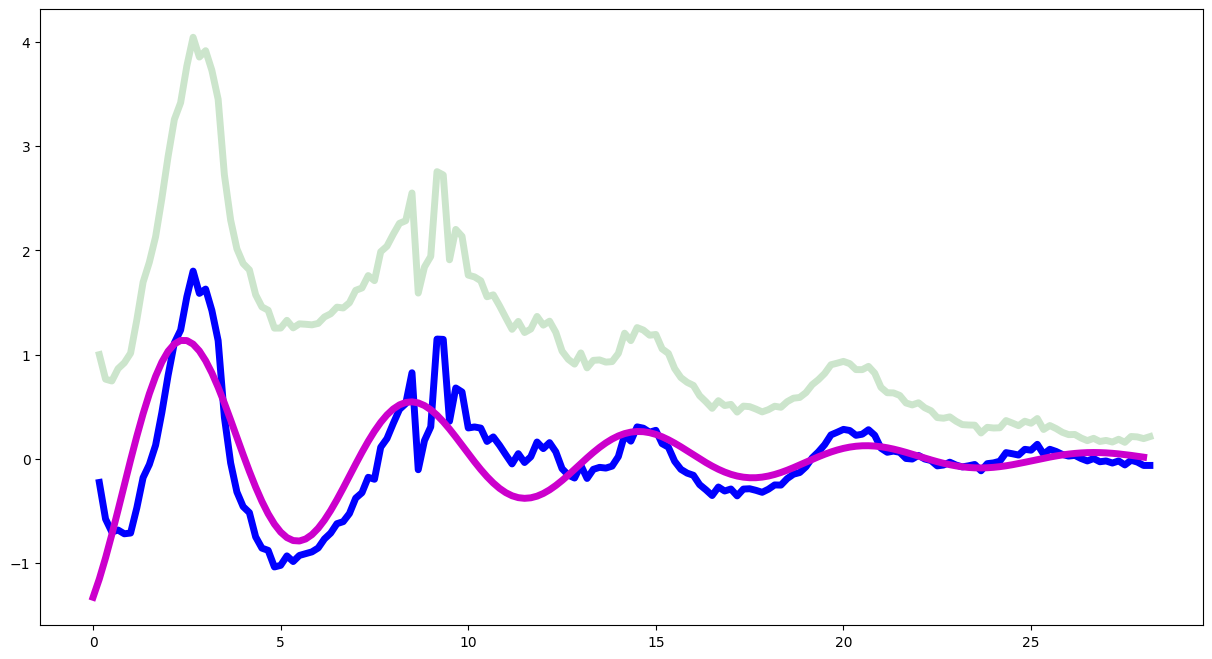

0.10559567936108592 0.08989037284481435


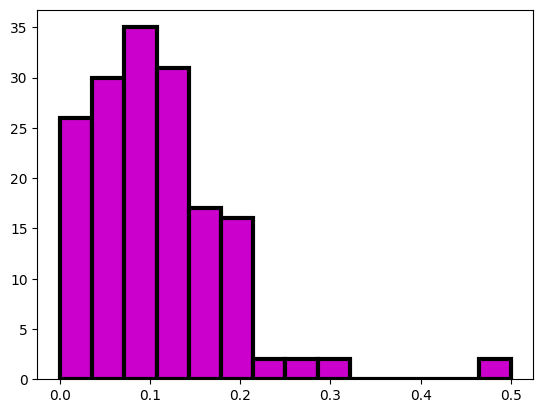

0.10559567936108592 0.08989037284481435


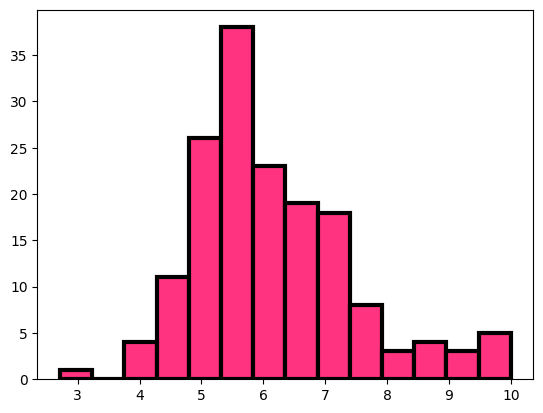

In [10]:
from scipy import optimize
from matplotlib.pyplot import figure


def test_func(x, a, b,c):
    return a *np.sin(b * x + c)

def test_func_decay(x, a, b,c,d):
    return a *np.exp(-d*x)*np.sin(b * x + c)
Pars = []

npol = 5


Fs = 6.  # Sampling rate
T = 1/Fs  # Sampling interval
Peaks = []
MAGS = []
Pers = []
c = 0
DD_good = []
Decay = []

for i in idx_good:
    x = DD[i,:]
    x /= x[0]
    
    tstart = 0
    tend = 170
    tf = t[tstart:tend]-t[tstart];
    fxn = np.polyfit(tf,x[tstart:tend],npol)
    
    s = 0
    for ffi in range(len(fxn)):
        s += fxn[ffi]*tf**(npol-ffi)
    xn = x[tstart:tend]-s
    #plt.plot(t[36:],s,'--r',lw=3) 
    x2 = savgol_filter(xn, 15, 2)
    #fft_result = np.fft.fft(x2)
    fft_result = np.fft.fft(xn)
    N = len(fft_result)
    frequencies = np.fft.fftfreq(N, T)     
    half = int(N/2)
    freq = frequencies[:half]
    # Compute the magnitude of the FFT
    magnitude = np.abs(fft_result);       
    magx = magnitude[:half]
    fmin = freq[np.argmax(magx)]
    Permax = 1/(fmin)
    if (Permax>10):
        Permax = 5.5
   
    
    params, params_covariance = optimize.curve_fit(test_func, tf, xn,
                                               p0=[np.max(x2), 2*np.pi/5.5,np.pi])
    param_bounds=([-np.inf,0,-np.inf],[np.inf,2,np.inf])
    params_decay, params_covariance_decay = optimize.curve_fit(test_func_decay, tf, xn,bounds=([0,2*np.pi/10,0,0], [10, 2*np.pi/1, 2*np.pi,.5]),
                                               p0=[np.max(x2), 2*np.pi/5.5,np.pi,0.1])
    if (np.max(x[:36])>0.5*np.max(x[36:])):
        Pars.append([params_decay[3],2*np.pi/params_decay[1]])
        if (i==12):
            plt.figure(figsize=(15, 8))
            plt.plot(t,x,'g',lw=5,alpha=0.2)
            plt.plot(t,xn,'b',lw=5)
            plt.plot(tf,test_func_decay(tf,params_decay[0],params_decay[1],params_decay[2],params_decay[3]),color = [.8,0,0.8],lw=5)
            plt.show()      
        c+=1
Pers = np.array(Pers)


Pars = np.array(Pars)
plt.hist((Pars[:,0]), 14,edgecolor = 'k',facecolor = [0.8,.0,0.8],lw=3)
print(np.mean(Pars[:,0]),np.median(Pars[:,0]))
#plt.xscale("log")
plt.show()
print(np.mean(Pars[:,0]),np.median(Pars[:,0]))

plt.hist((Pars[:,1]), 14,edgecolor = 'k',facecolor = [1,.2,0.5],lw=3)
plt.show()